# **Modelling**

## Objectives

* Build and evaluate baseline classification models that predict hazardous status using geometric and orbital features (diameter, miss_distance, relative_velocity, absolute_magnitude, observations).

## Inputs

* `features.csv` with adjustments suggested in conclusion to visualisations notebook to balance classes and aid modelling, principally:
    * introduce binned classes for very skewed features, particularly to aid building tree based models
    * Drop values (e.g. very small asteroids) to rebalance dataset, particularly in regard to our target value, hazardous status.
    * Select features to suit different models - e.g. log features for Logistic Regression, binned classes for Random Forest etc. 


## Outputs

* Trained baseline models: Logistic Regression (with regularization), Random Forest, XGBoost (optional).
* Evaluation artifacts: cross-validated metrics (ROC-AUC, PR-AUC), confusion matrices, calibration plots, feature importance (coefficients/SHAP).
* Results table comparing models.
* Saved dataset with new features and adjustments

## Success Criteria

* Reproducible pipeline: running the notebook top-to-bottom recreates models and metrics.
* At least one model achieves ROC-AUC > 0.70 (adjust threshold if class imbalance makes this infeasible); or shows improvement over a baseline (random or constant classifier).
* Models are interpretable: logistic regression coefficients make sense (direction), and feature importances/SHAP align with EDA findings.



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\Near-Earth-Asteroid-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\Near-Earth-Asteroid-Analysis'

# Remodelling Data

#### Objectives

To remodel data in line with summary at conclusion of `Visualistions.ipynb`
* Load data from `features.csv`
* Select target boundaries to drop values for low diameter & extremely distant asteroids prior to created binned features (so as not to distort ranges)
* Create binned classes for our very skewed features - display new distributions
* Check for consistency of data - features are better balanced, particularly for our target variable

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import plotly.graph_objects as go not sure will need this
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
## Load the processed features data
df = pd.read_csv('data/processed/features.csv')
df.head()

,name,est_diameter_min,est_diameter_max,relative_velocity_mean,miss_distance_mean,miss_distance_min,absolute_magnitude_mean,hazardous,observations,est_diameter_range,est_diameter_mean,est_diameter_min_log1p,est_diameter_max_log1p,est_diameter_mean_log1p,est_diameter_range_log1p,relative_velocity_mean_log1p,miss_distance_mean_log1p,miss_distance_min_log1p,hazardous_enc
0,(1983 LC),0.342417,0.765667,60192.646491,1.847664e+07,1.033448e+07,19.45,True,2,0.423250,0.554042,0.294472,0.568529,0.440859,0.352943,11.005322,16.732018,16.150996,1
1,(1986 NA),0.284810,0.636854,51810.077045,7.005246e+07,7.005246e+07,19.85,False,1,0.352044,0.460832,0.250611,0.492776,0.379006,0.301618,10.855359,18.064755,18.064755,0
2,(1988 NE),0.402305,0.899580,22815.738845,6.506331e+07,6.506331e+07,19.10,False,1,0.497276,0.650942,0.338117,0.641633,0.501346,0.403647,10.035250,17.990871,17.990871,0
3,(1989 AZ),0.319562,0.714562,55184.046572,2.560466e+07,2.021980e+07,19.60,False,2,0.395000,0.517062,0.277300,0.539158,0.416776,0.332895,10.918447,17.058285,16.822173,0
4,(1991 GO),0.265800,0.594347,92501.896829,3.695728e+07,2.702563e+07,20.00,True,2,0.328547,0.430073,0.235704,0.466464,0.357726,0.284086,11.434995,17.425273,17.112296,1


The first objective is to decide boundaries for dropping outlier data, for ranges which would not be considered hazardous and therefore add noise to the model with no gain. 
* Very small diameter asteroids
* Very distant asteroids

The threshold for asteroids to be considered potentially dangerous is 140m according to [NASA](https://cneos.jpl.nasa.gov/about/neo_groups.html), however we can check our data to find a reasonable boundary. I will check maximum and mean measures to see where the boundary is in the data.

In [ ]:
# find minimum size of potentially hazardous objects checking both mean, min and max estimated diameter
hazardous_asteroids = df[df['hazardous'] == True]
min_size_hazardous = hazardous_asteroids[['est_diameter_mean', 'est_diameter_max', 'est_diameter_min']].min()
min_size_hazardous

est_diameter_mean    0.142411
est_diameter_max     0.196807
est_diameter_min     0.088015
dtype: float64

From this we can see that the measure of 140m holds - there are no hazardous asteroids with a mean diameter less than this.

In [30]:
#drop asteroids with mean diameter < 140m
df_model = df[df['est_diameter_mean'] >= 0.14]
df_model.shape, df.shape

((10155, 19), (27423, 19))

In [24]:
print(df['hazardous'].value_counts(), df_model['hazardous'].value_counts())

hazardous
False    25250
True      2173
Name: count, dtype: int64 hazardous
False    8491
True     2173
Name: count, dtype: int64


This has considerably reduced our dataset, whilst preserving our target data. While the scale of reduction may be quite extreme I believe it is justifed in terms of project/ business requirements.
* As our principal project aim is identifying potentially hazardous or impact-significant asteroids, then sub-140 m objects are essentially out of scope and add noise.
* They won’t be treated differently by hazard classifiers because they can’t be hazardous by definition.
* With hindsight this step should have been taken earlier project - though it perhaps emphasises the iterative nature of Data Analysis!

Our next question is how to handle outliers for miss distance. Referring again to [NASA](https://cneos.jpl.nasa.gov/about/neo_groups.html) which classifies hazardous asteroids as  all asteroids with an Earth Minimum Orbit Intersection Distance (MOID) of 0.05 au or less (about 7.5million km). However we do not have orbital data, just a snapshot of proximity. Asteroids with extreme elliptical orbits may pass within this range but may also be observed at much greater distances. Let us check the data again.

In [26]:
# find maximum distances of potentially hazardous objects checking both mean and min distance
hazardous_asteroids = df[df['hazardous'] == True]
max_distance_hazardous = hazardous_asteroids[['miss_distance_mean', 'miss_distance_min']].max()
max_distance_hazardous

miss_distance_mean    7.470231e+07
miss_distance_min     7.470231e+07
dtype: float64

This is obviously quite a bit larger (10 times) than the measurement for MOID, suggesting asteroids with an eccentric or extreme orbit around earth - without orbital information we cannot say.

In [29]:
df['miss_distance_mean'].max(), df['miss_distance_min'].max()

(74798651.4521972, 74798651.4521972)

We can see from this that hazardous objects are found at the extreme end of distance scale and so there would be little value in dropping any values, other than to normalise skewed data. With this in mind we will proceed to creating binned classes for some of our data. First lets do a quick visual check.

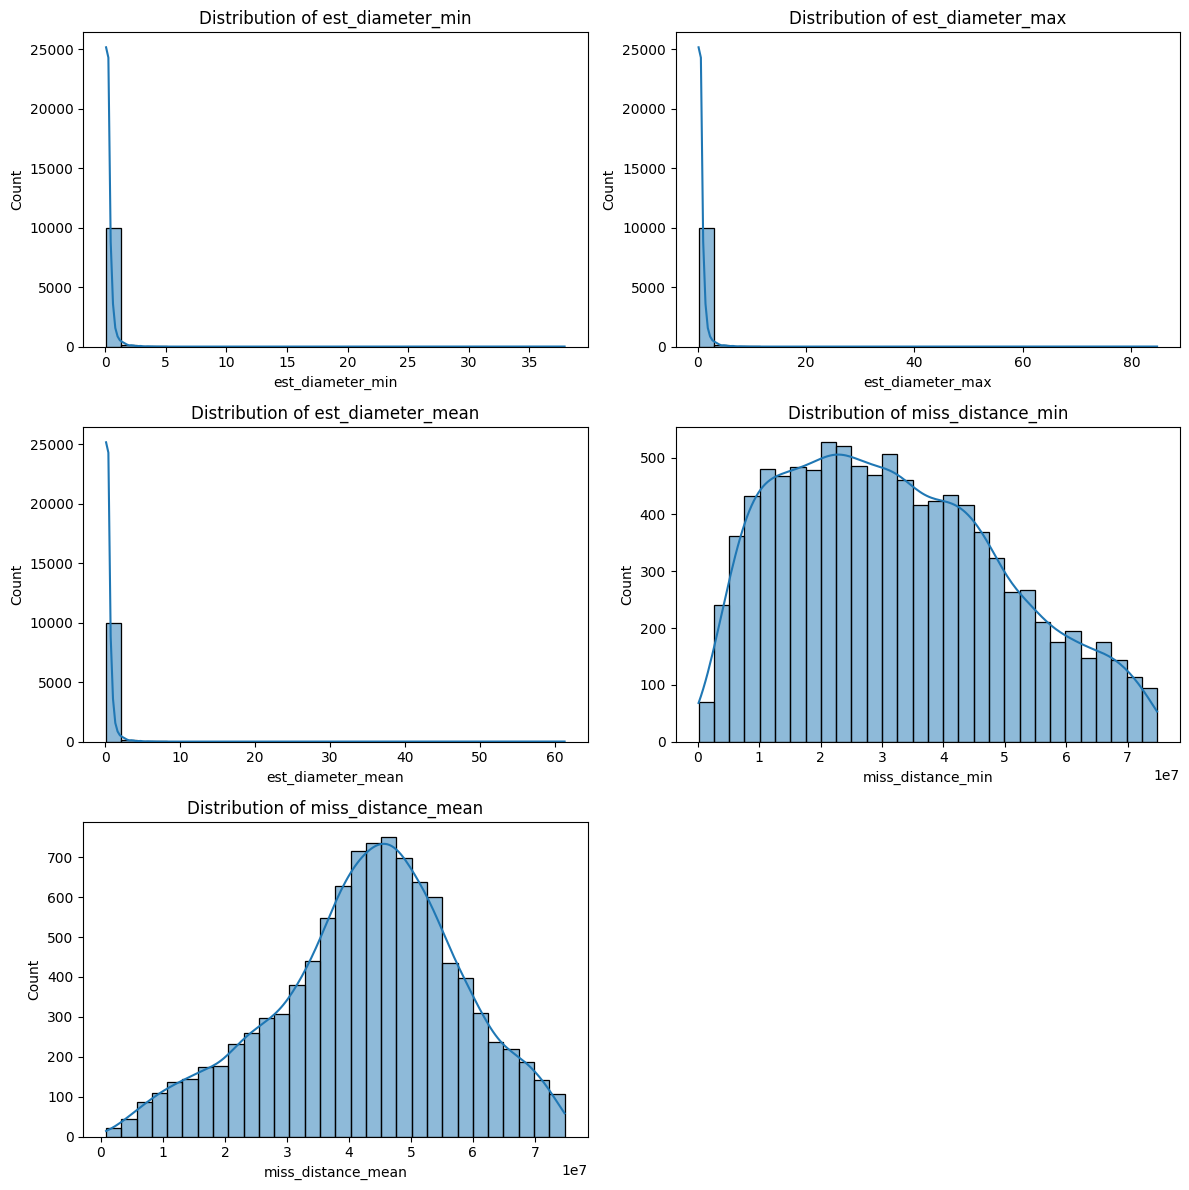

In [33]:
features = [
    "est_diameter_min", "est_diameter_max", "est_diameter_mean",
    "miss_distance_min", "miss_distance_mean"
]

plt.figure(figsize=(12, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_model[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

This confirms what our statistical tests our Visualisations notebook suggested - that very small asteroids with small miss distances distorted the data - miss_distance now has much more normal distribution, even though values were dropped on the basis of size.

*Speculative Reason*
* Small asteroids tend to be observed more when they are close to earth?

---

# Adding Classifications

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---